In [1]:
import jax.numpy as jnp
import numpy as np
from scipy import special
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan, cond
from jax import random
from jax import nn
import jax
import arviz as az
from matplotlib import pyplot as plt
import pandas as pd
az.rcParams["plot.max_subplots"] = 200
plt.rc('font', size=16, family='arial') 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
from scipy import stats

from matplotlib import pyplot as plt

import os
import pickle
import setup

import seaborn as sns
from rl_models import *

from numpyro.diagnostics import hpdi

from utils import plot_mean_hpdi, nanmovmean

# Load recovery results

In [2]:
processed_data_dir = "../data/Processed"
processed_file_name = "processed"
figure_data_dir = "/Users/f005d7d/Documents/Attn_MdPRL/Py-attention-project-analysis/figures/All Processed"

with open(os.path.join(processed_data_dir, "mcmc_recovery"), 'rb') as f:
    all_models_mcmc_recovery = pickle.load(f)

with open(os.path.join(processed_data_dir, "mcmc"), 'rb') as f:
    all_models_mcmc = pickle.load(f)


# Model Recovery

In [3]:
label_mapper = {
    'F_ACL': f'$F_{{ACL}}$',
    'F_AC': f'$F_{{AC}}$',
    'F_AL': f'$F_{{AL}}$',
    'F_UA': f'$F$',
    'O': f'$O$',
}

compare_dict = {
    gen_m_name: {} for gen_m_name in label_mapper.keys()
}

for k, v in all_models_mcmc_recovery.items():
    if len(k)!=2: 
        continue
    inf_data = az.from_numpyro(v)
    log_lik = inf_data.log_likelihood
    log_lik['choice_total'] = log_lik.sum('choice_dim_0').to_array()
    compare_dict[k[0]][k[1]] = az.waic(inf_data, var_name='choice_total')

elpd_diff = np.empty((5, 5))*np.nan
elpd_diff_ses = np.empty((5, 5))*np.nan

for gen_m_idx, gen_m in enumerate(label_mapper.keys()):
    comp_df = az.compare(compare_dict[gen_m], ic='waic')

    elpd_diff[gen_m_idx] = comp_df.loc[label_mapper.keys(),'elpd_diff']
    elpd_diff_ses[gen_m_idx] = comp_df.loc[label_mapper.keys(),'dse']

/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/f005d7d/opt/miniconda3/envs/hbi/lib/python

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vn/04h3k2gd41v70zhrqdwyg9cw0000gp/T/ipykernel_14216/259719816.py:9: SyntaxWarning: invalid escape sequence '\p'
  elpd_annot[-1].append(f'{np.round(elpd_diff[gen_m_idx, fit_m_idx], 1)}$\pm${np.round(elpd_diff_ses[gen_m_idx, fit_m_idx], 1)}')
/var/folders/vn/04h3k2gd41v70zhrqdwyg9cw0000gp/T/ipykernel_14216/259719816.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.title('$\Delta$ WAIC')


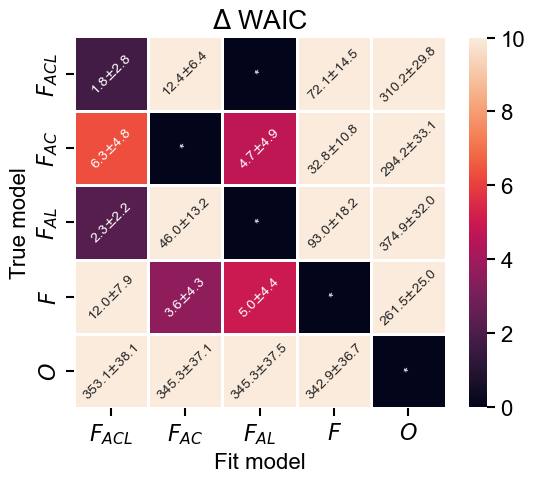

In [4]:
elpd_annot = []

for gen_m_idx in range(len(label_mapper.keys())):
    elpd_annot.append([])
    for fit_m_idx in range(len(label_mapper.keys())):
        if np.isclose(elpd_diff[gen_m_idx, fit_m_idx], 0):
            elpd_annot[-1].append('*')
        else:
            elpd_annot[-1].append(f'{np.round(elpd_diff[gen_m_idx, fit_m_idx], 1)}$\pm${np.round(elpd_diff_ses[gen_m_idx, fit_m_idx], 1)}')
    
fig, axes = plt.subplots(figsize=(6, 6))
sns.heatmap(elpd_diff, vmin=0, vmax=10, annot=elpd_annot, 
            fmt = '', annot_kws={'fontsize': 10, 'rotation': 45},
            ax=axes, square=True, linewidth=1, cbar_kws={'shrink': 0.8})
plt.title('$\Delta$ WAIC')
plt.xticks(np.arange(5)+0.5, label_mapper.values())
plt.yticks(np.arange(5)+0.5, label_mapper.values())
plt.xlabel('Fit model')
plt.ylabel('True model')
plt.savefig(os.path.join(figure_data_dir, "rl_model_recovery.pdf"))

# Parameter Recovery

In [5]:
best_fit_m = 'F_AL'
num_params = all_models_mcmc_recovery[best_fit_m]['params'].shape[2]


group_mean_params = all_models_mcmc_recovery[(best_fit_m,best_fit_m)].get_samples()['mu']
subj_params = np.array(all_models_mcmc_recovery[(best_fit_m,best_fit_m)].get_samples()['subj_params'])

subj_params[...,1] = np.exp(subj_params[...,1])
subj_params[...,2:] = special.ndtr(subj_params[...,2:])
recovered_params_median = np.median(subj_params, axis=0)
recovered_params_hpdi = hpdi(subj_params, prob=0.95, axis=0)

recovered_params_err = np.stack([
    recovered_params_median-recovered_params_hpdi[0],
    recovered_params_hpdi[1]-recovered_params_median
], 0)


transformed_true_params = np.array(all_models_mcmc_recovery[best_fit_m]['params'][0])
transformed_true_params[...,1] = np.exp(transformed_true_params[...,1])
transformed_true_params[...,2:] = special.ndtr(transformed_true_params[...,2:])

bad_recovery = np.logical_or(recovered_params_hpdi[0]>transformed_true_params, recovered_params_hpdi[1]<transformed_true_params)

print(f'badly recovered params total {bad_recovery.sum()} or {np.round(bad_recovery.mean()*100, 2)}%, ')

badly recovered params total 19 or 3.03%, 


In [6]:
az.summary(az.from_numpyro(all_models_mcmc_recovery[(best_fit_m, best_fit_m)]), 
           var_names=['mu', 'sigma'], stat_focus='median', hdi_prob=0.95)

,median,mad,eti_2.5%,eti_97.5%,mcse_median,ess_median,ess_tail,r_hat
mu[0],-0.026,0.026,-0.102,0.048,0.000,7911.048,6054.0,1.00
mu[1],1.324,0.055,1.161,1.483,0.002,2331.923,3383.0,1.01
mu[2],-1.551,0.127,-1.963,-1.199,0.006,1984.038,2743.0,1.00
mu[3],-2.422,0.267,-3.486,-1.827,0.008,4363.222,3995.0,1.00
mu[4],-1.686,0.161,-2.217,-1.265,0.006,2486.711,3667.0,1.00
mu[5],-2.436,0.227,-3.400,-1.947,0.005,5425.813,4589.0,1.00
mu[6],-2.438,0.213,-3.421,-1.995,0.006,5473.944,3780.0,1.00
mu[7],-0.901,0.072,-1.125,-0.692,0.003,2980.230,3459.0,1.00
mu[8],-2.858,0.261,-3.860,-2.283,0.007,5993.438,4731.0,1.00
mu[9],-1.221,0.087,-1.489,-0.975,0.004,2144.007,2883.0,1.00


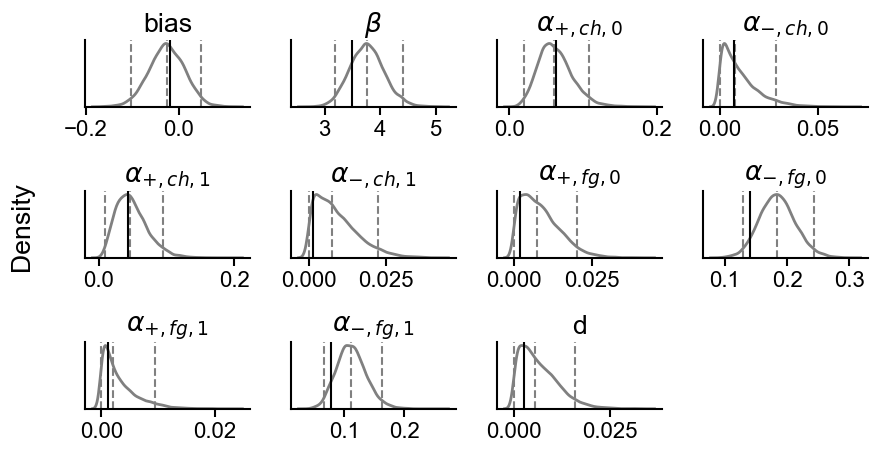

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(9,4.8))

param_names = ['bias', r'$\beta$', 
               r'$\alpha_{+,ch,0}$', r'$\alpha_{-,ch,0}$', 
               r'$\alpha_{+,ch,1}$', r'$\alpha_{-,ch,1}$', 
               r'$\alpha_{+,fg,0}$', r'$\alpha_{-,fg,0}$', 
               r'$\alpha_{+,fg,1}$', r'$\alpha_{-,fg,1}$', 
               'd']

sns.kdeplot((group_mean_params[:,0]), ax=axes[0,0], color='grey', lw=2)
curr_param_hpdi = hpdi((group_mean_params[:,0]), prob=0.95)
curr_param_median = np.median((group_mean_params[:,0]), axis=0)
axes[0,0].axvline(curr_param_median, ls='--', c='grey')
axes[0,0].axvline(curr_param_hpdi[0], ls='--', c='grey')
axes[0,0].axvline(curr_param_hpdi[1], ls='--', c='grey')
axes[0,0].axvline((np.median(all_models_mcmc[best_fit_m].get_samples()['mu'][:,0],0)), c='k')
axes[0,0].set_ylabel('')
axes[0,0].set_yticks([])
axes[0,0].set_title(param_names[0])

sns.kdeplot(np.exp(group_mean_params[:,1]), ax=axes[0,1], color='grey', lw=2)
curr_param_hpdi = hpdi(np.exp(group_mean_params[:,1]), prob=0.95)
curr_param_median = np.median(np.exp(group_mean_params[:,1]), axis=0)
axes[0,1].axvline(curr_param_median, ls='--', c='grey')
axes[0,1].axvline(curr_param_hpdi[0], ls='--', c='grey')
axes[0,1].axvline(curr_param_hpdi[1], ls='--', c='grey')
axes[0,1].axvline(np.exp(np.median(all_models_mcmc[best_fit_m].get_samples()['mu'][:,1],0)), c='k')
axes[0,1].set_ylabel('')
axes[0,1].set_yticks([])
axes[0,1].set_title(param_names[1])

for i in range(2, 11):
    sns.kdeplot(special.ndtr(group_mean_params[:,i]), ax=axes[i//4, i%4], color='grey', lw=2)
    curr_param_hpdi = hpdi(special.ndtr(group_mean_params[:,i]), prob=0.95)
    curr_param_median = np.median(special.ndtr(group_mean_params[:,i]), axis=0)
    axes[i//4, i%4].axvline(curr_param_median, ls='--', c='grey')
    axes[i//4, i%4].axvline(curr_param_hpdi[0], ls='--', c='grey')
    axes[i//4, i%4].axvline(curr_param_hpdi[1], ls='--', c='grey')
    axes[i//4, i%4].axvline(special.ndtr(np.median(all_models_mcmc[best_fit_m].get_samples()['mu'][:,i],0)), c='k')
    axes[i//4, i%4].set_ylabel('')
    axes[i//4, i%4].set_yticks([])
    axes[i//4, i%4].set_title(param_names[i])

fig.supylabel('Density')

for i in range(num_params, 12):
    axes[i//4, i%4].remove()
    
sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(figure_data_dir, "rl_param_recovery_group.pdf"))


SignificanceResult(statistic=0.13857920663728288, pvalue=0.30393033080669113)
SignificanceResult(statistic=0.637671765620949, pvalue=9.577041429987058e-08)
SignificanceResult(statistic=0.8298548094373868, pvalue=1.483883448144848e-15)
SignificanceResult(statistic=0.1853124189784807, pvalue=0.16756551719141827)
SignificanceResult(statistic=0.675265750583355, pvalue=8.336085879136052e-09)
SignificanceResult(statistic=-0.07337308789214415, pvalue=0.587533317230784)
SignificanceResult(statistic=0.05198340679284419, pvalue=0.7009554592326905)
SignificanceResult(statistic=0.5930775213896812, pvalue=1.1659284876963393e-06)
SignificanceResult(statistic=0.10215193155302049, pvalue=0.44957421364352945)
SignificanceResult(statistic=0.6391625615763546, pvalue=8.74825213180342e-08)
SignificanceResult(statistic=0.08542908996629506, pvalue=0.5274894634312666)


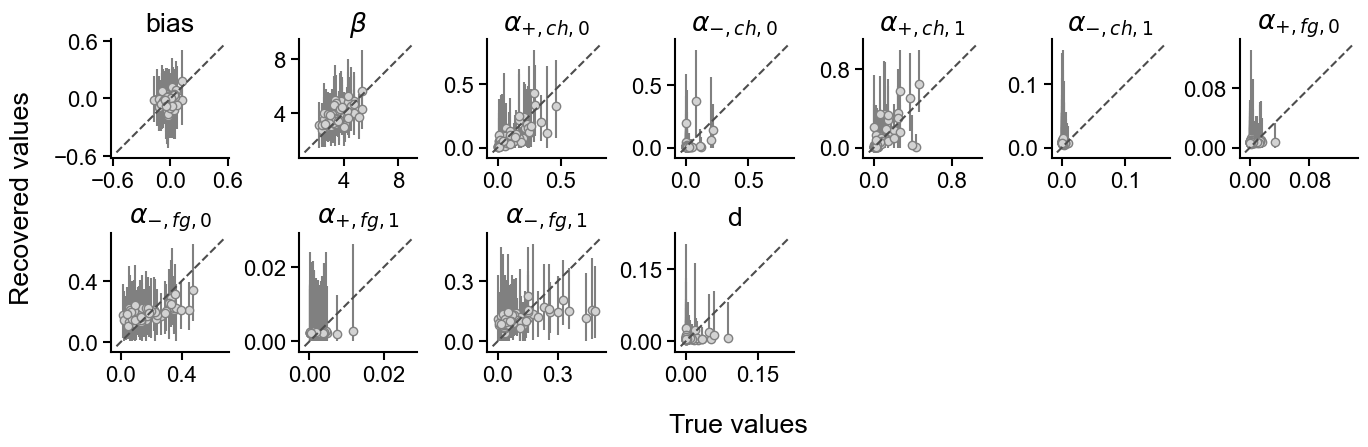

In [19]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(2, 7, figsize=(14,4.8))

for i in range(num_params):
    axes[i//7, i%7].errorbar(x=transformed_true_params[:,i], 
                             y=recovered_params_median[:,i],
                             yerr=recovered_params_err[...,i], ls='', c='grey')
    axes[i//7, i%7].scatter(x=transformed_true_params[:,i], 
                            y=recovered_params_median[:,i], 
                            c='lightgrey', edgecolors='grey', zorder=2)
    
    axlims = [min(axes[i//7, i%7].get_xlim()[0], axes[i//7, i%7].get_ylim()[0]),
              max(axes[i//7, i%7].get_xlim()[1], axes[i//7, i%7].get_ylim()[1])]
    axes[i//7, i%7].plot(axlims, axlims, ls="--", c=".3")
    axes[i//7, i%7].set_title(param_names[i])
    axes[i//7, i%7].set_aspect('equal', 'box')
    axes[i//7, i%7].tick_params(axis='x', labelsize=16)
    axes[i//7, i%7].tick_params(axis='y', labelsize=16)
    axes[i//7, i%7].xaxis.set_major_locator(ticker.MaxNLocator(2))
    axes[i//7, i%7].yaxis.set_major_locator(ticker.MaxNLocator(2))
    print(stats.spearmanr(transformed_true_params[:,i], recovered_params_median[:,i]))
    

for i in range(num_params, 14):
    axes[i//7, i%7].remove()

fig.supxlabel('True values', y=0.05, x=0.54)    
fig.supylabel('Recovered values', y=0.55)    
sns.despine()
plt.tight_layout(w_pad=0.6, h_pad=0.3)


plt.savefig(os.path.join(figure_data_dir, "rl_param_recovery_subj.pdf"))


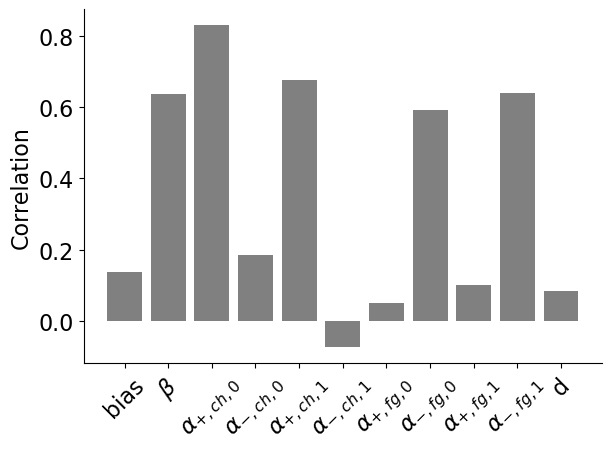

In [37]:
recovery_corr = stats.spearmanr(transformed_true_params, recovered_params_median)

plt.bar(np.arange(num_params), 
        np.diag(recovery_corr.statistic, k=num_params), color='grey')
plt.xticks(np.arange(num_params), param_names, rotation=45)
plt.ylabel('Correlation')
sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(figure_data_dir, "rl_param_recovery_corr.pdf"))